In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from fycharts.SpotifyCharts import SpotifyCharts
import sqlalchemy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller  

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

In [15]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/capstone/code'

**Reading in data for each country- 2017-2019; 2020**

In [16]:
italy_17_19 = pd.read_pickle('../data/it_17_19_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_feat.pkl')

In [17]:
italy_20 = pd.read_pickle('../data/it_20_feat.pkl')
spain_20 = pd.read_pickle('../data/sp_20_feat.pkl')
greece_20 = pd.read_pickle('../data/gr_20_feat.pkl')

**Resampling by month**

_`rm` denotes resampling by month._ 

In [18]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

In [19]:
rm_italy_20 = italy_20.resample("M").mean()
rm_spain_20 = spain_20.resample("M").mean()
rm_greece_20 = greece_20.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [20]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

In [21]:
rw_italy_20 = italy_20.resample("W").mean()
rw_spain_20 = spain_20.resample("W").mean()
rw_greece_20 = greece_20.resample("W").mean()

# SARIMAX model 

### Dickey-Fuller and Differencing 

Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [22]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [23]:
interpret_dftest(rw_italy_17_19['acousticness'].values.reshape(-1).tolist())

Test Statistic    0.194297
p-value           0.195347
dtype: float64

In [24]:
type(interpret_dftest(rw_italy_17_19['acousticness'].values.reshape(-1).tolist()))

pandas.core.series.Series

In [25]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [26]:
dickey_dict = {
'danceability':[], 
 'energy':[],
 'key':[],
 'loudness':[],
 'mode':[],
 'speechiness':[],
 'acousticness':[],
 'instrumentalness':[],
 'liveness':[],
 'valence':[],
 'tempo':[]
    
}

for feature in audio_features:
    dickey_dict[feature].append(f'{interpret_dftest(rw_italy_17_19[feature].values.reshape(-1).tolist())}')

In [27]:
dickey_dict

{'danceability': ['Test Statistic    0.64154\np-value           0.63785\ndtype: float64'],
 'energy': ['Test Statistic    0.693575\np-value           0.695850\ndtype: float64'],
 'key': ['Test Statistic    5.240\np-value           4.905\ndtype: float64'],
 'loudness': ['Test Statistic   -5.822415\np-value          -5.922195\ndtype: float64'],
 'mode': ['Test Statistic    0.570\np-value           0.565\ndtype: float64'],
 'speechiness': ['Test Statistic    0.099410\np-value           0.105253\ndtype: float64'],
 'acousticness': ['Test Statistic    0.194297\np-value           0.195347\ndtype: float64'],
 'instrumentalness': ['Test Statistic    0.010463\np-value           0.016614\ndtype: float64'],
 'liveness': ['Test Statistic    0.164927\np-value           0.156222\ndtype: float64'],
 'valence': ['Test Statistic    0.500168\np-value           0.483813\ndtype: float64'],
 'tempo': ['Test Statistic    116.706005\np-value           116.596895\ndtype: float64']}

In [28]:
pd.DataFrame(dickey_dict).T

,0
danceability,Test Statistic 0.64154\np-value 0...
energy,Test Statistic 0.693575\np-value ...
key,Test Statistic 5.240\np-value 4.9...
loudness,Test Statistic -5.822415\np-value -...
mode,Test Statistic 0.570\np-value 0.5...
speechiness,Test Statistic 0.099410\np-value ...
acousticness,Test Statistic 0.194297\np-value ...
instrumentalness,Test Statistic 0.010463\np-value ...
liveness,Test Statistic 0.164927\np-value ...
valence,Test Statistic 0.500168\np-value ...


In [29]:
for feature in audio_features:
    print(f'Dickey_Fuller interpretation for {feature}:\n{interpret_dftest(rw_italy_17_19[feature].values.reshape(-1).tolist())}')    

Dickey_Fuller interpretation for danceability:
Test Statistic    0.64154
p-value           0.63785
dtype: float64
Dickey_Fuller interpretation for energy:
Test Statistic    0.693575
p-value           0.695850
dtype: float64
Dickey_Fuller interpretation for key:
Test Statistic    5.240
p-value           4.905
dtype: float64
Dickey_Fuller interpretation for loudness:
Test Statistic   -5.822415
p-value          -5.922195
dtype: float64
Dickey_Fuller interpretation for mode:
Test Statistic    0.570
p-value           0.565
dtype: float64
Dickey_Fuller interpretation for speechiness:
Test Statistic    0.099410
p-value           0.105253
dtype: float64
Dickey_Fuller interpretation for acousticness:
Test Statistic    0.194297
p-value           0.195347
dtype: float64
Dickey_Fuller interpretation for instrumentalness:
Test Statistic    0.010463
p-value           0.016614
dtype: float64
Dickey_Fuller interpretation for liveness:
Test Statistic    0.164927
p-value           0.156222
dtype: float6

### Once-differenced data

In [30]:
lag_df = rw_italy_17_19.copy()
lag_df.head()

,Position,Streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,
2017-01-08,100.5,145502.475,0.64154,0.693575,5.240,-5.822415,0.570,0.099410,0.194297,0.010463,0.164927,0.500168,116.706005,219129.85,3.995
2017-01-15,100.5,158424.445,0.63785,0.695850,4.905,-5.922195,0.565,0.105253,0.195347,0.016614,0.156222,0.483813,116.596895,215693.64,3.975
2017-01-22,100.5,166912.255,0.64331,0.706035,5.185,-5.789885,0.600,0.104810,0.189541,0.010576,0.157828,0.503616,117.256720,216752.93,4.000
2017-01-29,100.5,169132.215,0.64082,0.689941,5.110,-6.047320,0.595,0.101993,0.189309,0.011057,0.154504,0.495657,117.879770,215713.19,4.000
2017-02-05,100.5,181889.905,0.64247,0.693566,5.250,-5.921840,0.565,0.104047,0.193047,0.014126,0.151522,0.488651,116.862095,213350.36,3.990


In [31]:
lag_df.shape

(155, 15)

In [32]:
for feature in audio_features: 
    lag_df[f'{feature}_once_differenced'] = lag_df[feature].diff(1).fillna(0)

In [33]:
lag_df.head()

,Position,Streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2017-01-08,100.5,145502.475,0.64154,0.693575,5.240,-5.822415,0.570,0.099410,0.194297,0.010463,...,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-15,100.5,158424.445,0.63785,0.695850,4.905,-5.922195,0.565,0.105253,0.195347,0.016614,...,0.002275,-0.335,-0.099780,-0.005,0.005843,0.001050,0.006151,-0.008704,-0.016355,-0.109110
2017-01-22,100.5,166912.255,0.64331,0.706035,5.185,-5.789885,0.600,0.104810,0.189541,0.010576,...,0.010185,0.280,0.132310,0.035,-0.000443,-0.005805,-0.006037,0.001606,0.019803,0.659825
2017-01-29,100.5,169132.215,0.64082,0.689941,5.110,-6.047320,0.595,0.101993,0.189309,0.011057,...,-0.016094,-0.075,-0.257435,-0.005,-0.002817,-0.000232,0.000480,-0.003324,-0.007959,0.623050
2017-02-05,100.5,181889.905,0.64247,0.693566,5.250,-5.921840,0.565,0.104047,0.193047,0.014126,...,0.003625,0.140,0.125480,-0.030,0.002054,0.003738,0.003070,-0.002982,-0.007006,-1.017675


In [34]:
# for feature in audio_features:
#     print(f'Dickey_Fuller interpretation for {feature}, once-differenced:\n{interpret_dftest(lag_df[{feature}_once_differenced].values.reshape(-1).tolist())}')

In [35]:
for feature in audio_features:
    print(f'Dickey_Fuller interpretation for {feature}, once-differenced:\n{interpret_dftest(lag_df[feature].diff(1).fillna(0).values.reshape(-1).tolist())}')

Dickey_Fuller interpretation for danceability, once-differenced:
Test Statistic    0.00000
p-value          -0.00369
dtype: float64
Dickey_Fuller interpretation for energy, once-differenced:
Test Statistic    0.000000
p-value           0.002275
dtype: float64
Dickey_Fuller interpretation for key, once-differenced:
Test Statistic    0.000
p-value          -0.335
dtype: float64
Dickey_Fuller interpretation for loudness, once-differenced:
Test Statistic    0.00000
p-value          -0.09978
dtype: float64
Dickey_Fuller interpretation for mode, once-differenced:
Test Statistic    0.000
p-value          -0.005
dtype: float64
Dickey_Fuller interpretation for speechiness, once-differenced:
Test Statistic    0.000000
p-value           0.005843
dtype: float64
Dickey_Fuller interpretation for acousticness, once-differenced:
Test Statistic    0.00000
p-value           0.00105
dtype: float64
Dickey_Fuller interpretation for instrumentalness, once-differenced:
Test Statistic    0.000000
p-value     

In [36]:
for feature in audio_features:
    print(f'Dickey_Fuller interpretation for {feature}, twice-differenced:\n{interpret_dftest(lag_df[feature].diff(2).fillna(0).values.reshape(-1).tolist())}')

Dickey_Fuller interpretation for danceability, twice-differenced:
Test Statistic    0.0
p-value           0.0
dtype: float64
Dickey_Fuller interpretation for energy, twice-differenced:
Test Statistic    0.0
p-value           0.0
dtype: float64
Dickey_Fuller interpretation for key, twice-differenced:
Test Statistic    0.0
p-value           0.0
dtype: float64
Dickey_Fuller interpretation for loudness, twice-differenced:
Test Statistic    0.0
p-value           0.0
dtype: float64
Dickey_Fuller interpretation for mode, twice-differenced:
Test Statistic    0.0
p-value           0.0
dtype: float64
Dickey_Fuller interpretation for speechiness, twice-differenced:
Test Statistic    0.0
p-value           0.0
dtype: float64
Dickey_Fuller interpretation for acousticness, twice-differenced:
Test Statistic    0.0
p-value           0.0
dtype: float64
Dickey_Fuller interpretation for instrumentalness, twice-differenced:
Test Statistic    0.0
p-value           0.0
dtype: float64
Dickey_Fuller interpreta

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

In [37]:
from pmdarima.arima.utils import ndiffs

In [38]:
rw_italy_17_19[rw_italy_17_19['danceability'].isnull()]

,Position,Streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity: {ndiffs(rw_italy_17_19[feature].dropna(), test= "adf")}')

ndiffs for danceability stationarity: 1
ndiffs for energy stationarity: 1
ndiffs for key stationarity: 1
ndiffs for loudness stationarity: 1
ndiffs for mode stationarity: 1
ndiffs for speechiness stationarity: 0
ndiffs for acousticness stationarity: 1
ndiffs for instrumentalness stationarity: 1
ndiffs for liveness stationarity: 1
ndiffs for valence stationarity: 1
ndiffs for tempo stationarity: 0


### Building ARIMA model 

_ARIMA model for 'valence'_

In [40]:
len(rw_italy_17_19['valence'])

155

In [41]:
155*.75

116.25

In [54]:
rw_italy_17_19[rw_italy_17_19['valence'].isnull()]

,Position,Streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
train_valence = rw_italy_17_19['valence'].fillna(0)[1:117]
test_valence = rw_italy_17_19['valence'].fillna(0)[117::]

In [84]:
rw_italy_17_19.isnull().sum()

Position            2
Streams             2
danceability        2
energy              2
key                 2
loudness            2
mode                2
speechiness         2
acousticness        2
instrumentalness    2
liveness            2
valence             2
tempo               2
duration_ms         2
time_signature      2
dtype: int64

In [85]:
model_valence = ARIMA(train_valence, order=(2,1,2))

model_valence_fit = model_valence.fit()

In [86]:
rw_greece_17_19.loc[['2019-04-21 00:00:00']]

,Position,Streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,
2019-04-21,100.5,16939.655,0.719425,0.617346,5.51,-6.80917,0.495,0.142558,0.230301,0.011309,0.165923,0.443227,118.051025,203388.695,3.98


In [87]:
model_valence_fit.predict()

date
2017-01-22   -0.000391
2017-01-29   -0.010075
2017-02-05   -0.002131
2017-02-12    0.003020
2017-02-19    0.002470
                ...   
2019-03-03   -0.007559
2019-03-10   -0.018095
2019-03-17   -0.021344
2019-03-24   -0.020178
2019-03-31   -0.024939
Freq: W-SUN, Length: 115, dtype: float64

In [90]:
preds_train_valence_arima_212 = model_valence_fit.predict(start=train_valence.index[1], end=train_valence.index[-1])

In [91]:
preds_test_valence_arima_212 = model_valence_fit.predict(start=test_valence.index[0], end=test_valence.index[-1])

In [72]:
train_valence.shape

(116,)

In [74]:
preds_train_valence_arima_212.shape

(115,)

In [92]:
preds_train_valence_arima_212

date
2017-01-22   -0.000391
2017-01-29   -0.010075
2017-02-05   -0.002131
2017-02-12    0.003020
2017-02-19    0.002470
                ...   
2019-03-03   -0.007559
2019-03-10   -0.018095
2019-03-17   -0.021344
2019-03-24   -0.020178
2019-03-31   -0.024939
Freq: W-SUN, Length: 115, dtype: float64

In [75]:
train_valence

date
2017-01-15    0.483813
2017-01-22    0.503616
2017-01-29    0.495657
2017-02-05    0.488651
2017-02-12    0.488101
                ...   
2019-03-03    0.481602
2019-03-10    0.484794
2019-03-17    0.483369
2019-03-24    0.488169
2019-03-31    0.480123
Freq: W-SUN, Name: valence, Length: 116, dtype: float64

In [76]:
train_valence.index[1]

Timestamp('2017-01-22 00:00:00', freq='W-SUN')

In [93]:
# evaluating the ARIMA(2,1,2) model 

# RMSE 
train_rmse_valence = mean_squared_error(train_valence[1::], preds_train_valence_arima_212)**0.5
print(f'Train RMSE - ARIMA(2,1,2): {train_rmse_valence}')

test_rmse_valence = mean_squared_error(test_valence, preds_test_valence_arima_212)**0.5
print(f'Test RMSE - ARIMA(2,1,2): {test_rmse_valence}')

Train RMSE - ARIMA(2,1,2): 0.49589697575699804
Test RMSE - ARIMA(2,1,2): 0.5034497156859623


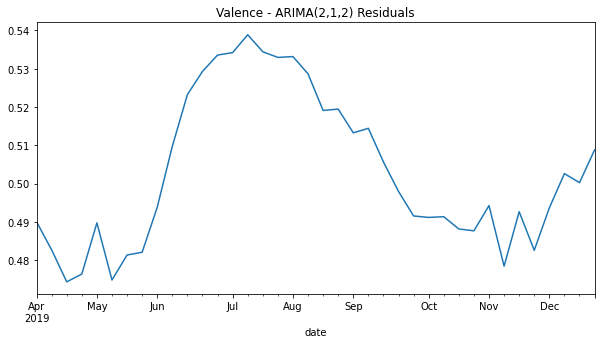

In [94]:
resids_valence_212 = test_valence - preds_test_valence_arima_212

resids_valence_212.plot(figsize=(10,5))
plt.title("Valence - ARIMA(2,1,2) Residuals");

In [96]:
output = model_valence_fit.forecast()
output

(array([0.46230827]), array([0.06633135]), array([[0.33230122, 0.59231532]]))

In [97]:
model_valence_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.valence   No. Observations:                  115
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 146.492
Method:                       css-mle   S.D. of innovations              0.066
Date:                Sun, 14 Feb 2021   AIC                           -280.983
Time:                        23:04:58   BIC                           -264.513
Sample:                    01-22-2017   HQIC                          -274.298
                         - 03-31-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0004      0.000     -2.041      0.041      -0.001   -1.55e-05
ar.L1.D.valence    -0.9591      0.021    -45.053      0.000      -1.001      -0.917
ar.L2.D.valence     0.0409      0.007      6.027      0.000       0.028       0.054
ma.L1.D.valence -3.538e-08        nan        nan        nan         nan         nan
ma.L2.D.valence    -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           +0.0000j            1.0000            0.5000
AR.2           24.4404           +0.0000j           24.4404            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

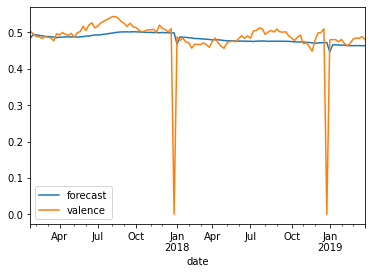

In [99]:
model_valence_fit.plot_predict(dynamic=False)
plt.show()